# Assignment: Image Classification Model Benchmarking

## Objective
Train and evaluate different image classification models on the **Plant Type Dataset** from Kaggle using **PyTorch** and **PyTorch Lightning**. Benchmark their performance and analyze results.

## Tasks

1. **Dataset**
   - Use the [Plant Type Dataset](https://www.kaggle.com/datasets/yudhaislamisulistya/plants-type-datasets).
   - Load and preprocess with `torch.utils.data.Dataset` and `DataLoader`.
   - Apply transforms (resize, normalization, augmentation).

2. **Models**
   - Implement at least **two models**:
     - A **SimpleCNN** (baseline).
     - A **pretrained model** (e.g., ResNet, VGG, or MobileNet).
   - Fine-tune pretrained weights for better performance.

3. **PyTorch Lightning**
   - Wrap models in a `LightningModule`.
   - Define `training_step`, `validation_step`, and `test_step`.
   - Use callbacks like `ModelCheckpoint` and `EarlyStopping`.

4. **Training & Evaluation**
   - Train on the training set, tune with validation data.
   - Evaluate final models on the test set.
   - Compare metrics and analyze results.

## Evaluation Metrics
- **Accuracy**
- **Loss**
- Precision, Recall, F1-score, Confusion Matrix.

## Deliverable
A well-documented **Colab notebook** including:
- Data loading and preprocessing code.
- Model implementation and training with Lightning.
- Evaluation results and visualizations.
- Instructions for accessing the Kaggle dataset (via Kaggle API or upload).

## Tips
- Install Kaggle API: `!pip install kaggle`
- Start with simpler models or pretrained models to get a baseline.
- Experiment with learning rate, batch size, and epochs.
- Refer to the PyTorch and TorchVision documentation for details on datasets, models, and transforms.


# 0️⃣ Plant Dataset

# **1. Dataset**
   - Use the [Plant Type Dataset](https://www.kaggle.com/datasets/yudhaislamisulistya/plants-type-datasets).
   - Load and preprocess with `torch.utils.data.Dataset` and `DataLoader`.
   - Apply transforms (resize, normalization, augmentation).


Install and import the necessary modules.

In [1]:
!pip install kaggle

In [2]:
! pip install lightning
! pip install torchview

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 34.5 MB/s eta 0:00:00


In [3]:
# ===============================
# PyTorch Core Modules
# ===============================
import torch  # Core tensor operations
from torch import Tensor
import torch.nn as nn  # Neural network layers
import torch.nn.functional as F  # Functional API for activations, losses, etc.
import torch.optim as optim  # Optimizers
from torch.utils.data import Dataset, DataLoader, random_split  # Dataset utilities

# ===============================
# PyTorch Ecosystem
# ===============================
import pytorch_lightning as pl  # High-level training framework
import torchmetrics  # Model evaluation metrics
from torchview import draw_graph  # Model visualization
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor # Callbacks

# ===============================
# TorchVision - For image data
# ===============================
import torchvision  # Pretrained models and datasets
import torchvision.transforms as transforms  # Image preprocessing utilities
import torchvision.models as models

# ===============================
# Scikit-learn - Data generation and preprocessing
# ===============================
from sklearn.datasets import make_regression  # Synthetic regression data
from sklearn.model_selection import train_test_split  # Train/test splitting
from sklearn.preprocessing import MinMaxScaler  # Feature scaling

# ===============================
# Visualization
# ===============================
import matplotlib.pyplot as plt  # Plotting utilities

# ===============================
# Numerical Computing
# ===============================
import numpy as np  # Array operations
import math  # Basic mathematical functions\
import pandas as pd

from PIL import Image
import requests
import io
import json

## Load and preprocess the dataset with `torch.utils.data.Dataset` and `DataLoader`

Import the dataset from **kaggle**.

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yudhaislamisulistya/plants-type-datasets")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plants-type-datasets' dataset.
Path to dataset files: /kaggle/input/plants-type-datasets


In [5]:
import os
os.listdir("/kaggle/input/plants-type-datasets")

['split_ttv_dataset_type_of_plants']

Define a custom class `PlantDataset` which inherits from PyTorch `Dataset`. This custom dataset class is designed to work with image datasets organized in a hierarchical structure where each subfolder within the *img_dir* represents a different class.

In [6]:
import os
from torchvision.io import read_image
from torch.utils.data import Dataset
import pandas as pd

import glob

class PlantDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: path to the dataset split (e.g., '.../train' or '.../test')
        transform: torchvision transforms to apply to each image
        """
        self.root_dir = root_dir
        self.transform = transform

        # Get all image paths recursively
        self.image_paths = glob.glob(os.path.join(root_dir, "*/*.jpg")) + \
                           glob.glob(os.path.join(root_dir, "*/*.png")) + \
                           glob.glob(os.path.join(root_dir, "*/*.jpeg"))

        # Extract labels from folder names
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_name = os.path.basename(os.path.dirname(img_path))
        label = self.class_to_idx[label_name]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# class PlantDataset(Dataset):
#     def __init__(self, img_dir, transform=None):
#         self.img_dir = img_dir
#         self.transform = transform
#         self.image_files = []
#         self.labels = []
#         self.classes = sorted([d.name for d in os.scandir(img_dir) if d.is_dir()])
#         self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

#         for class_name in self.classes:
#             class_dir = os.path.join(img_dir, class_name)
#             for img_name in os.listdir(class_dir):
#                 self.image_files.append(os.path.join(class_dir, img_name))
#                 self.labels.append(self.class_to_idx[class_name])


#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, idx):
#         img_path = self.image_files[idx]
#         image = read_image(img_path)
#         label = self.labels[idx]

#         if self.transform:
#             image = self.transform(image)

#         return image, label

## Apply transforms (resize, normalization, augmentation).

Defining image transformations.

- Define transformations with augmentation for the training set

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
    transforms.RandomRotation(15), # Randomly rotate the image by up to 15 degrees
    transforms.ToTensor(), # Convert image to float
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize pixel values
])

- Define transformations without augmentation for the validation and test sets


In [8]:
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(), # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize pixel values
])

Create the dataset instances for training, validation and testing using the `PlantDataset` class.

In [9]:
base_dir = os.path.join(path, 'split_ttv_dataset_type_of_plants')
train_dir = os.path.join(base_dir, 'Train_Set_Folder')
val_dir = os.path.join(base_dir, 'Validation_Set_Folder')
test_dir = os.path.join(base_dir, 'Test_Set_Folder')

# Create the datasets
train_dataset = PlantDataset(root_dir=train_dir, transform=train_transform)
val_dataset = PlantDataset(root_dir=val_dir, transform=val_test_transform)
test_dataset = PlantDataset(root_dir=test_dir, transform=val_test_transform)

- Used `train_transform` with augmentation for the training dataset and `val_test_transform` without augmentation for the validation and testing datasets.

In [10]:
# Determine the number of classes from the training dataset
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

# Define the number of input channels
input_channels = 3 # 3 color channels (RGB)
print(f"Input channels: {input_channels}")

Number of classes: 30
Input channels: 3


Set up the data loaders for training, validation, and testing using `DataLoader`.

In [11]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 23972
Number of validation samples: 3030
Number of test samples: 2998


Display some sample images from the training dataset.

Labels:  papaya mango guava bilimbi


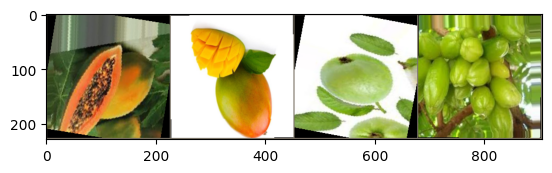

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get a batch of training data
images, labels = next(iter(train_loader))

# Define the mean and standard deviation used for normalization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)


# Function to show images
def imshow(img):
    # Unnormalize the image
    unnormalized_img = img * std + mean
    npimg = unnormalized_img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Print images and labels
print('Labels: ', ' '.join(f'{train_dataset.classes[labels[j]]}' for j in range(4)))
imshow(torchvision.utils.make_grid(images[:4]))

# 1️⃣ Baseline model `SimpleCNN`

# **2.1. Models**
   - Implement at least **two models**:
     - A **SimpleCNN** (baseline).
     - A **pretrained model** (e.g., ResNet, VGG, or MobileNet).
   - Fine-tune pretrained weights for better performance.

## SimpleCNN Model (baseline)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # 3 input channels, 32 output channels, 3x3 kernel
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 2x2 max pooling

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 32 input channels, 64 output channels
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        # The size of the input to the first fully connected layer depends on the output of the convolutional layers
        # With 224x224 input images, after two conv/pool layers (2x2 maxpool with stride 2), the spatial dimensions become (224/2)/2 = 56x56
        self.fc1 = nn.Linear(64 * 56 * 56, 128) # 64 channels * 56x56 spatial dimensions
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes) # Output layer with num_classes for classification

    def forward(self, x):
        # Apply first convolutional block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # Apply second convolutional block
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # Flatten the tensor for the fully connected layers
        x = torch.flatten(x, 1) # Flatten starting from dimension 1 (batch dimension is 0)

        # Apply fully connected layers
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        return x

# Instantiate the CNN model
cnn_model = SimpleCNN(num_classes)

print("Simple CNN Model defined:")
print(cnn_model)

Simple CNN Model defined:
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=30, bias=True)
)


# **3.1 PyTorch Lightning**
   - Wrap models in a `LightningModule`.
   - Define `training_step`, `validation_step`, and `test_step`.
   - Use callbacks like `ModelCheckpoint` and `EarlyStopping`.

## Visualizse the Plant Lightning Module



Implement the Lightning Module of the Plant Dataset, which inherits from `pl.LightningModule`.

In [ ]:
class PlantLightningModule(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters() # Saves hyperparameters like num_classes and learning_rate
        self.model = SimpleCNN(num_classes) # Our CNN model
        self.criterion = nn.CrossEntropyLoss() # Loss function for classification
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes) # Metric for accuracy

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(outputs, labels))
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images)
        loss = self.criterion(outputs, labels)
        self.log('val_loss', loss)
        self.log('val_acc', self.accuracy(outputs, labels))
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images)
        loss = self.criterion(outputs, labels)
        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy(outputs, labels))
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

# Instantiate the Lightning Module
plant_model = PlantLightningModule(num_classes=30)

print("Plant Lightning Module defined.")
print(plant_model)

Plant Lightning Module defined.
PlantLightningModule(
  (model): SimpleCNN(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=200704, out_features=128, bias=True)
    (relu3): ReLU()
    (fc2): Linear(in_features=128, out_features=30, bias=True)
  )
  (criterion): CrossEntropyLoss()
  (accuracy): MulticlassAccuracy()
)


We can use `torchview` to visualize the architecture of our `PlantLightningModule`, which wraps the `SimpleCNN`. This helps in understanding the flow of data through the layers of the CNN.

We will create a dummy input tensor matching the expected input shape of a Plant Dataset image and then use `draw_graph` to generate the plot.

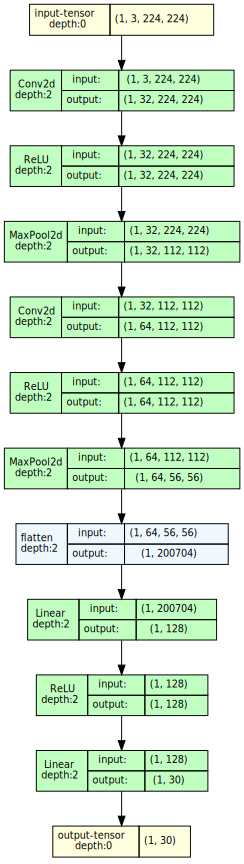

In [ ]:
# Instantiate the PlantLightningModule
# We need to provide the same parameters as when it was defined
plant_model_for_graph = PlantLightningModule(num_classes=30)

# Create a dummy input tensor for Plant Dataset images
# CIFAR-10 images are 3 channels (RGB) and 32x32 pixels
dummy_input_plant = torch.randn(1, 3, 224, 224)

# Use draw_graph to visualize the PlantLightningModule
plant_model_graph = draw_graph(
    model=plant_model_for_graph,
    input_data=dummy_input_plant,
    graph_name='Plant Dataset Lightning Module Visualization', # Name for the generated graph
    # Set depth to a higher valu"e if you want to see more nested modules
    depth=3 # Adjust this to see more or less detail of the nested SimpleCNN
)

# Display the visual graph
plant_model_graph.visual_graph

# **4.1. Training & Evaluation**
   - Train on the training set, tune with validation data.
   - Evaluate final models on the test set.
   - Compare metrics and analyze results.

## Train & Test the SimpleCNN `PlantLightningModel`


In [ ]:
# Model Checkpoint Callback
# Saves the model's weights based on a monitored metric (e.g., validation accuracy)
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc', # Metric to monitor
    mode='max',        # 'max' means we want to maximize the monitored metric
    dirpath='checkpoints/', # Directory to save checkpoints
    filename='best-plant-model', # Name for the checkpoint file
    save_top_k=1,      # Save only the best model based on the monitored metric
    verbose=True       # Print a message when a checkpoint is saved
)

# Early Stopping Callback
# Stops training early if the monitored metric doesn't improve for a certain number of epochs
early_stopping_callback = EarlyStopping(
    monitor='val_loss', # Metric to monitor
    mode='min',         # 'min' means we want to minimize the monitored metric
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    verbose=True        # Print a message when early stopping is triggered
)

# Learning Rate Monitor Callback
# Logs the learning rate during training. Useful for learning rate scheduling.
lr_monitor_callback = LearningRateMonitor(logging_interval='step') # Log learning rate at each step

# Instantiate the PyTorch Lightning Trainer
# You can configure various options here, e.g., gpus, max_epochs, etc.
trainer = pl.Trainer(
    max_epochs=10, # Train for a few more epochs to see callbacks in action
    accelerator='auto', # Use GPU if available, otherwise CPU
    devices=1,  # Use 1 device (GPU or CPU)
    callbacks=[checkpoint_callback, early_stopping_callback, lr_monitor_callback] # Pass the list of callbacks to the Trainer
)

# Start Training
print("Starting Plant Dataset training with callbacks...")
trainer.fit(plant_model, train_loader, val_loader)

# Test the model after training
print("\nStarting Plant Dataset testing...")

# For simplicity here, we just test the model in its final state after training
trainer.test(plant_model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Starting Plant Dataset training with callbacks...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | SimpleCNN          | 25.7 M | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | accuracy  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
25.7 M    Trainable params
0         Non-trainable params
25.7 M    Total params
102.854   Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 2.864
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 375: 'val_acc' reached 0.14983 (best 0.14983), saving model to '/content/checkpoints/best-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.685 >= min_delta = 0.0. New best score: 2.179
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 750: 'val_acc' reached 0.32211 (best 0.32211), saving model to '/content/checkpoints/best-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.419 >= min_delta = 0.0. New best score: 1.761
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1125: 'val_acc' reached 0.44191 (best 0.44191), saving model to '/content/checkpoints/best-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.143 >= min_delta = 0.0. New best score: 1.617
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1500: 'val_acc' reached 0.48416 (best 0.48416), saving model to '/content/checkpoints/best-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 1.545
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1875: 'val_acc' reached 0.50264 (best 0.50264), saving model to '/content/checkpoints/best-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.111 >= min_delta = 0.0. New best score: 1.434
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 2250: 'val_acc' reached 0.54290 (best 0.54290), saving model to '/content/checkpoints/best-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.142 >= min_delta = 0.0. New best score: 1.292
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 2625: 'val_acc' reached 0.58614 (best 0.58614), saving model to '/content/checkpoints/best-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.267
INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 3000: 'val_acc' reached 0.59670 (best 0.59670), saving model to '/content/checkpoints/best-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 3375: 'val_acc' reached 0.60363 (best 0.60363), saving model to '/content/checkpoints/best-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.235
INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 3750: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Starting Plant Dataset testing...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6047365069389343     │
│         test_loss         │    1.2450727224349976     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.2450727224349976, 'test_acc': 0.6047365069389343}]

- We can observe that the final *test loss* is **1.24** and *test accuracy* is **0.60** for a simple CNN.

## Examine SimpleCNN Test Results

Following the training and testing of our Simple CNN `PlantModel` model, this section visualizes several test images. We'll display the images alongside their true labels and the model's predictions to evaluate its performance on individual examples.

Plotting some test samples from Plant Dataset with predictions:


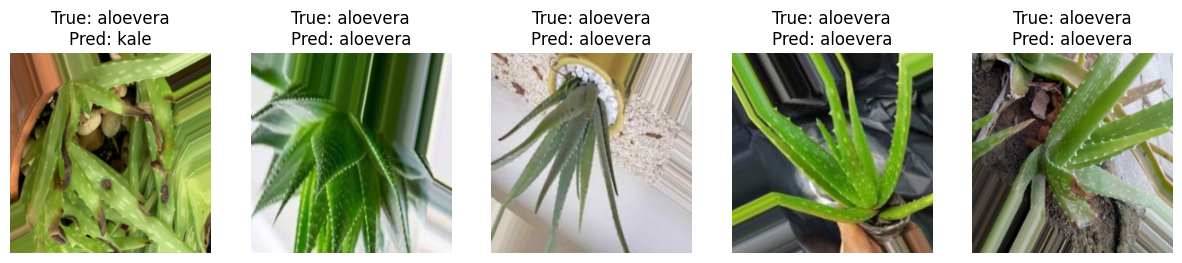

In [ ]:
# Plot some test samples and their predictions
print("Plotting some test samples from Plant Dataset with predictions:")

# Get one batch of test data from the Plant Dataset test_loader
test_images_cifar, test_labels_cifar = next(iter(test_loader))

# Move images to the same device as the model and get predictions
# Assuming cifar10_model is already instantiated and trained
device = next(plant_model.parameters()).device # Get the device of the model
test_images_cifar = test_images_cifar.to(device)

with torch.no_grad(): # No need to calculate gradients for inference
    outputs = plant_model(test_images_cifar)
    # Get the index of the class with the highest probability
    _, predicted_labels_cifar = torch.max(outputs, 1)

# Move data back to CPU for plotting if needed
test_images_cifar = test_images_cifar.cpu()
test_labels_cifar = test_labels_cifar.cpu()
predicted_labels_cifar = predicted_labels_cifar.cpu()

# Display the first few images with true and predicted labels
fig_cifar, axes_cifar = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    # Unnormalize the image for display (Plant Dataset normalization used mean and std of 0.5)
    img_cifar = test_images_cifar[i] * 0.5 + 0.5     # Unnormalize
    npimg_cifar = img_cifar.numpy()
    # Matplotlib expects shape (height, width, channels)
    npimg_cifar = np.transpose(npimg_cifar, (1, 2, 0))

    axes_cifar[i].imshow(npimg_cifar)
    axes_cifar[i].set_title(f"True: {test_dataset.classes[test_labels_cifar[i]]}\nPred: {test_dataset.classes[predicted_labels_cifar[i]]}")
    axes_cifar[i].axis('off')

plt.show()

# 2️⃣ Pretrained model `VGG16`

# **2.2. Models**
   - Implement at least **two models**:
     - A **SimpleCNN** (baseline).
     - A **pretrained model** (e.g., ResNet, VGG, or MobileNet).
   - Fine-tune pretrained weights for better performance.

## Pretrained Model (VGG 16)

Load the pretrained model VGG16 and visualize its shape and structure for a dummy input tensor that matches the expected input shape of one image for our **Plant Dataset**.

In [ ]:
# Load a pretrained VGG16 model
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Modify the classifier for the number of classes in your dataset
# The last layer of VGG16's classifier is a fully connected layer with 4096 input features
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, num_classes) # num_classes was determined earlier from the dataset

print("Pretrained VGG16 Model with modified classifier:")
print(vgg16)

# Example of using the VGG16 model with a dummy input
# Create a dummy input tensor matching the expected input shape (batch_size, channels, height, width)
# Assuming input images are 224x224 as per the transforms
dummy_input_vgg = torch.randn(1, 3, 224, 224)

# Put the model in evaluation mode
vgg16.eval()

# Move the input to the same device as the model (if using GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dummy_input_vgg = dummy_input_vgg.to(device)
vgg16.to(device)

# Get predictions (logits) from the VGG16 model
with torch.no_grad(): # No need to calculate gradients for inference
    output_vgg = vgg16(dummy_input_vgg)

print("\nOutput shape from VGG16 with dummy input:", output_vgg.shape)

Pretrained VGG16 Model with modified classifier:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool

# **3.2 PyTorch Lightning**
   - Wrap models in a `LightningModule`.
   - Define `training_step`, `validation_step`, and `test_step`.
   - Use callbacks like `ModelCheckpoint` and `EarlyStopping`.

## Visualizse the VGG16 Plant Lightning Module



Implement the `VGGPlantLigthingModule` for our dataset, which inherits from `pl.LightningModule`.


In [ ]:
class VGGPlantLightningModule(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()
        # Load a pretrained VGG16 model
        self.model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

        # Modify the classifier for the number of classes in your dataset
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(outputs, labels))
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images)
        loss = self.criterion(outputs, labels)
        self.log('val_loss', loss)
        self.log('val_acc', self.accuracy(outputs, labels))
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images)
        loss = self.criterion(outputs, labels)
        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy(outputs, labels))
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

# Instantiate the VGG16 Lightning Module
vgg_plant_model = VGGPlantLightningModule(num_classes=num_classes)

print("VGG16 Plant Lightning Module defined.")
print(vgg_plant_model)

VGG16 Plant Lightning Module defined.
VGGPlantLightningModule(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

We can use `torchview` to visualize the architecture of our `VGGPlantLightningModule`, which wraps the `VGG16` model. This helps in understanding the flow of data through the layers of the CNN.

We will create a dummy input tensor matching the expected input shape of a Plant Dataset image and then use `draw_graph` to generate the plot.

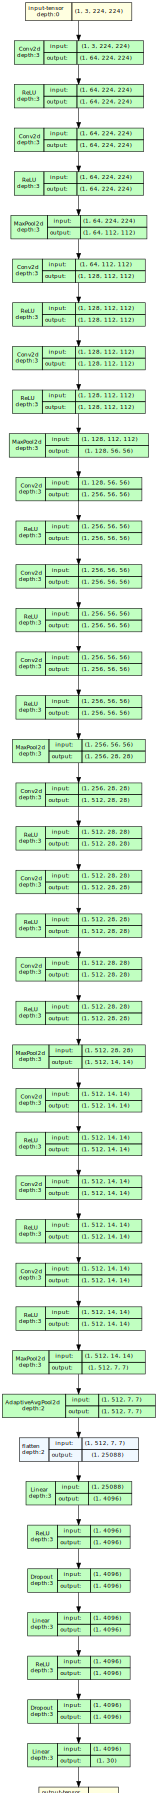

In [ ]:
# Instantiate the PlantLightningModule
# We need to provide the same parameters as when it was defined
plant_model_for_graph = VGGPlantLightningModule(num_classes=30)

# Create a dummy input tensor for Plant Dataset images
# CIFAR-10 images are 3 channels (RGB) and 32x32 pixels
dummy_input_plant = torch.randn(1, 3, 224, 224)

# Use draw_graph to visualize the PlantLightningModule
plant_model_graph = draw_graph(
    model=plant_model_for_graph,
    input_data=dummy_input_plant,
    graph_name='Plant Dataset Lightning Module Visualization', # Name for the generated graph
    # Set depth to a higher value if you want to see more nested modules
    depth=3 # Adjust this to see more or less detail
)

# Display the visual graph
plant_model_graph.visual_graph

# **4.2. Training & Evaluation**
   - Train on the training set, tune with validation data.
   - Evaluate final models on the test set.
   - Compare metrics and analyze results.

## Train & Test the Pretrained model `VGGPlantLightningModel`


In [ ]:
# Model Checkpoint Callback
checkpoint_callback_vgg = ModelCheckpoint(
    monitor='val_acc',
    mode='max',
    dirpath='checkpoints_vgg/', # Use a different directory for VGG checkpoints
    filename='best-vgg-plant-model',
    save_top_k=1,
    verbose=True
)

# Early Stopping Callback
early_stopping_callback_vgg = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=3,
    verbose=True
)

# Learning Rate Monitor Callback
lr_monitor_callback_vgg = LearningRateMonitor(logging_interval='step')

# Instantiate the PyTorch Lightning Trainer for VGG16
trainer_vgg = pl.Trainer(
    max_epochs=10, # Train for 10 epochs
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback_vgg, early_stopping_callback_vgg, lr_monitor_callback_vgg]
)

# Start Training for VGG16
print("Starting VGG16 Plant Dataset training with callbacks...")
trainer_vgg.fit(vgg_plant_model, train_loader, val_loader)

# Test the VGG16 model after training
print("\nStarting VGG16 Plant Dataset testing...")
trainer_vgg.test(vgg_plant_model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Starting VGG16 Plant Dataset training with callbacks...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | VGG                | 134 M  | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | accuracy  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.534   Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 3.400
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 375: 'val_acc' reached 0.03333 (best 0.03333), saving model to '/content/checkpoints_vgg/best-vgg-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.700 >= min_delta = 0.0. New best score: 2.699
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 750: 'val_acc' reached 0.16040 (best 0.16040), saving model to '/content/checkpoints_vgg/best-vgg-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.354 >= min_delta = 0.0. New best score: 2.346
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1125: 'val_acc' reached 0.24290 (best 0.24290), saving model to '/content/checkpoints_vgg/best-vgg-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.174 >= min_delta = 0.0. New best score: 2.171
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1500: 'val_acc' reached 0.29769 (best 0.29769), saving model to '/content/checkpoints_vgg/best-vgg-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.251 >= min_delta = 0.0. New best score: 1.921
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1875: 'val_acc' reached 0.36469 (best 0.36469), saving model to '/content/checkpoints_vgg/best-vgg-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 1.849
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 2250: 'val_acc' reached 0.39670 (best 0.39670), saving model to '/content/checkpoints_vgg/best-vgg-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.114 >= min_delta = 0.0. New best score: 1.735
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 2625: 'val_acc' reached 0.42640 (best 0.42640), saving model to '/content/checkpoints_vgg/best-vgg-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 3000: 'val_acc' reached 0.43069 (best 0.43069), saving model to '/content/checkpoints_vgg/best-vgg-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.158 >= min_delta = 0.0. New best score: 1.577
INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 3375: 'val_acc' reached 0.48548 (best 0.48548), saving model to '/content/checkpoints_vgg/best-vgg-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 1.523
INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 3750: 'val_acc' reached 0.48878 (best 0.48878), saving model to '/content/checkpoints_vgg/best-vgg-plant-model.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Starting VGG16 Plant Dataset testing...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.49299532175064087    │
│         test_loss         │    1.5687036514282227     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.5687036514282227, 'test_acc': 0.49299532175064087}]

- We observe that the final *test loss* for the pretrained VGG16 model is **1.56** and the *test accuracy* is **0.49**.
- Based on the low accuracy and high loss, we can draw the conclusion that the pretrained model might be overfitted, so we will remove
- These metrics show us that the pretrained model without fine tuned weights performs worse than a basline model, as it has a bigger loss and a lower accuracy.

# 3️⃣ Pretrained model `VGG16` - 1 linear layer in Classifier

# **2.3. Models:** VGG Model with only 1 linear layer for the **Classifier**

## Pretrained Model (VGG 16)

In [ ]:
# Load a pretrained VGG16 model
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Modify the classifier for the number of classes in the dataset
num_ftrs_after_avgpool = 512 * 7 * 7
vgg16.classifier = nn.Sequential(
    nn.Linear(num_ftrs_after_avgpool, num_classes)
)

print("Pretrained VGG16 Model with modified classifier:")
print(vgg16)

# Example of using the VGG16 model with a dummy input
# Create a dummy input tensor matching the expected input shape (batch_size, channels, height, width)
# Assuming input images are 224x224 as per the transforms
dummy_input_vgg = torch.randn(1, 3, 224, 224)

# Put the model in evaluation mode
vgg16.eval()

# Move the input to the same device as the model (if using GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dummy_input_vgg = dummy_input_vgg.to(device)
vgg16.to(device)

# Get predictions (logits) from the VGG16 model
with torch.no_grad(): # No need to calculate gradients for inference
    output_vgg = vgg16(dummy_input_vgg)

print("\nOutput shape from VGG16 with dummy input:", output_vgg.shape)

# **3.3. PyTorch Lightning**

## Visualizse the VGG16 Plant Lightning Module



We create a new `VGGPlantLightningModule` without the 6 classifier layers, leaving only the output layer.

In [26]:
class VGGPlantLightningModule(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()
        # Load a pretrained VGG16 model
        self.model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

        # Modify the classifier for the number of classes in the dataset
        # Determine the number of input features for the linear layer after avgpool
        # For VGG16 with 224x224 input and AdaptiveAvgPool2d(output_size=(7, 7)),
        # the output shape before the classifier is (batch_size, 512, 7, 7)
        # After flattening, it's batch_size * 512 * 7 * 7 = batch_size * 25088

        # Replace the entire classifier with a new Sequential module
        # containing only the final linear layer
        num_ftrs_after_avgpool = 512 * 7 * 7
        self.model.classifier = nn.Sequential(
            nn.Linear(num_ftrs_after_avgpool, num_classes)
        )

        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        # VGG forward pass includes features, avgpool, and then classifier
        # The modified classifier expects a flattened input
        x = self.model.features(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1) # Flatten the output from avgpool
        x = self.model.classifier(x) # Pass to the modified classifier

        return x

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images) # Use the modified forward pass
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(outputs, labels))
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images) # Use the modified forward pass
        loss = self.criterion(outputs, labels)
        self.log('val_loss', loss)
        self.log('val_acc', self.accuracy(outputs, labels))
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images) # Use the modified forward pass
        loss = self.criterion(outputs, labels)
        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy(outputs, labels))
        return loss


    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

# Instantiate the VGG16 Lightning Module
vgg_plant_model = VGGPlantLightningModule(num_classes=num_classes)

print("VGG16 Plant Lightning Module defined with corrected classifier input features.")
print(vgg_plant_model)

VGG16 Plant Lightning Module defined with corrected classifier input features.
VGGPlantLightningModule(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256,

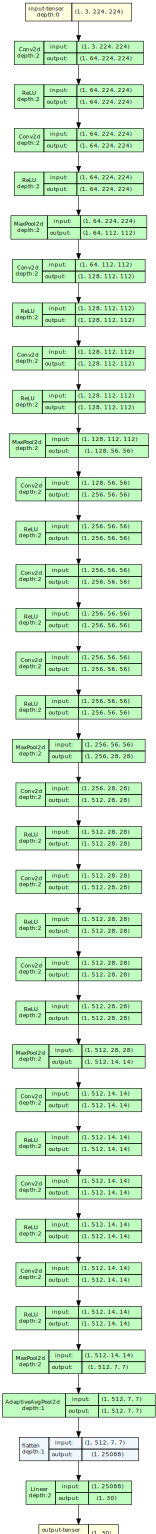

In [28]:
# Instantiate the PlantLightningModule
# We need to provide the same parameters as when it was defined
plant_model_for_graph = VGGPlantLightningModule(num_classes=30)

# Create a dummy input tensor for Plant Dataset images
# Assuming input images are 3 channels (RGB) and 224x224 pixels as per the transforms
dummy_input_plant = torch.randn(1, 3, 224, 224)

# Use draw_graph to visualize the PlantLightningModule
plant_model_graph = draw_graph(
    model=plant_model_for_graph,
    input_data=dummy_input_plant,
    graph_name='VGGPlantLightningModule Visualization', # Name for the generated graph
    depth=3 # Set depth to 3
)

# Display the visual graph
plant_model_graph.visual_graph

# **4.3. Training & Evaluation**
   - Train on the training set, tune with validation data.
   - Evaluate final models on the test set.
   - Compare metrics and analyze results.

## Train & Test the Pretrained model `VGGPlantLightningModel`


In [30]:
# Model Checkpoint Callback
checkpoint_callback_vgg = ModelCheckpoint(
    monitor='val_acc',
    mode='max',
    dirpath='checkpoints_vgg/', # Use a different directory for VGG checkpoints
    filename='best-vgg-plant-model',
    save_top_k=1,
    verbose=True
)

# Early Stopping Callback
early_stopping_callback_vgg = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=3,
    verbose=True
)

# Learning Rate Monitor Callback
lr_monitor_callback_vgg = LearningRateMonitor(logging_interval='step')

# Instantiate the PyTorch Lightning Trainer for VGG16
trainer_vgg = pl.Trainer(
    max_epochs=10, # Train for 10 epochs
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback_vgg, early_stopping_callback_vgg, lr_monitor_callback_vgg]
)

# Start Training for VGG16
print("Starting VGG16 Plant Dataset training with callbacks...")
trainer_vgg.fit(vgg_plant_model, train_loader, val_loader)

# Test the VGG16 model after training
print("\nStarting VGG16 Plant Dataset testing...")
trainer_vgg.test(vgg_plant_model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Starting VGG16 Plant Dataset training with callbacks...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | VGG                | 15.5 M | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | accuracy  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
15.5 M    Trainable params
0         Non-trainable params
15.5 M    Total params
61.869    Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 3.401
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 375: 'val_acc' reached 0.03333 (best 0.03333), saving model to '/content/checkpoints_vgg/best-vgg-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 3.401
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 750: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1125: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1500: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 3.401. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1875: 'val_acc' was not in top 1
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Starting VGG16 Plant Dataset testing...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.03335557132959366    │
│         test_loss         │    3.4012036323547363     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 3.4012036323547363, 'test_acc': 0.03335557132959366}]

- We observe that keeping only 1 layer for the classifier that generates the desired output for the plant dataset (30 classes) performs worse than having the full classifier layer.
- The final *test_loss* for this model is **3.40** and the final *test_acc* is **0.03**, values which are very bad
- This is why we will proceed with trying to fine-tune the VGG 16 model

## Examine Pretrained VGG model with Test Results

Following the training and testing of our Pretrained `VGGPlantModel` model, this section visualizes several test images. We'll display the images alongside their true labels and the model's predictions to evaluate its performance on individual examples.

Plotting some test samples from Plant Dataset with predictions:


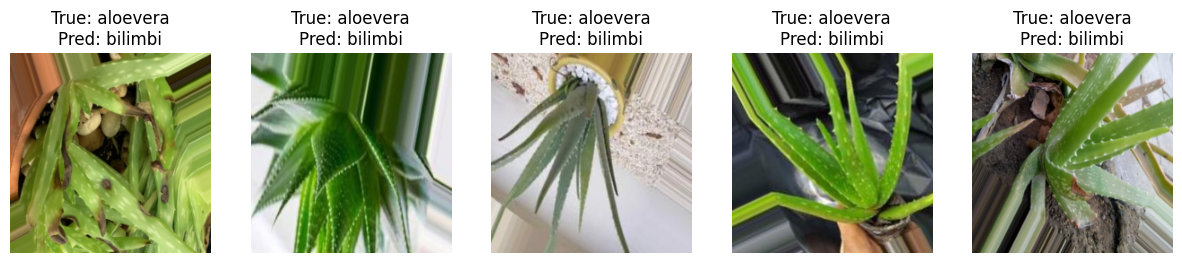

In [31]:
# Plot some test samples and their predictions
print("Plotting some test samples from Plant Dataset with predictions:")

# Get one batch of test data from the Plant Dataset test_loader
test_images_cifar, test_labels_cifar = next(iter(test_loader))

# Move images to the same device as the model and get predictions
# Assuming cifar10_model is already instantiated and trained
device = next(vgg_plant_model.parameters()).device # Get the device of the model
test_images_cifar = test_images_cifar.to(device)

with torch.no_grad(): # No need to calculate gradients for inference
    outputs = vgg_plant_model(test_images_cifar)
    # Get the index of the class with the highest probability
    _, predicted_labels_cifar = torch.max(outputs, 1)

# Move data back to CPU for plotting if needed
test_images_cifar = test_images_cifar.cpu()
test_labels_cifar = test_labels_cifar.cpu()
predicted_labels_cifar = predicted_labels_cifar.cpu()

# Display the first few images with true and predicted labels
fig_cifar, axes_cifar = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    # Unnormalize the image for display (Plant Dataset normalization used mean and std of 0.5)
    img_cifar = test_images_cifar[i] * 0.5 + 0.5     # Unnormalize
    npimg_cifar = img_cifar.numpy()
    # Matplotlib expects shape (height, width, channels)
    npimg_cifar = np.transpose(npimg_cifar, (1, 2, 0))

    axes_cifar[i].imshow(npimg_cifar)
    axes_cifar[i].set_title(f"True: {test_dataset.classes[test_labels_cifar[i]]}\nPred: {test_dataset.classes[predicted_labels_cifar[i]]}")
    axes_cifar[i].axis('off')

plt.show()

# 4️⃣ Pretrained model `VGG16` - fine tuned

# **2.4. Models:** Fine-tune pretrained weights for better performance

## Pretrained Model (VGG 16)

To fine tune the pretrained VGG model we will:
- Load a pretrained VGG16 model again to demonstrate fine-tuning
- Freeze all the layers in the features (convolutional) part of the model to be able to only train the classifier initially

In [32]:
# Work with a new instance to avoid modifying the previously trained one
vgg16_finetune = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze all the layers in the features (convolutional) part of the model
for param in vgg16_finetune.features.parameters():
    param.requires_grad = False

# Modify the classifier for the number of classes in the dataset
# The last layer of VGG16's classifier is a fully connected layer with 4096 input features
num_ftrs_finetune = vgg16_finetune.classifier[6].in_features
vgg16_finetune.classifier[6] = nn.Linear(num_ftrs_finetune, num_classes)

print("Pretrained VGG16 Model with frozen feature layers and modified classifier:")
print(vgg16_finetune)

Pretrained VGG16 Model with frozen feature layers and modified classifier:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inpla

# **3.4. PyTorch Lightning**

## Visualizse the VGG16 Plant Lightning Module



Now, we will wrap this `vgg16_finetune` model in the `VGGPlantLightningModule` and then train it. The optimizer in the `LightningModule` will only update the parameters that have *requires_grad=True* (which is
currently just the parameters in the modified classifier layer).

In [34]:
class FineTuneVGGPlantLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters(ignore=['model']) # Save other hyperparameters, but not the model itself
        self.model = model # Use the pre-configured VGG16 model with frozen layers
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=self.model.classifier[6].out_features) # Get num_classes from the modified layer

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(outputs, labels))
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images)
        loss = self.criterion(outputs, labels)
        self.log('val_loss', loss)
        self.log('val_acc', self.accuracy(outputs, labels))
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images)
        loss = self.criterion(outputs, labels)
        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy(outputs, labels))
        return loss

    def configure_optimizers(self):
        # The optimizer will only update parameters that have requires_grad=True
        # In this case, it will only train the modified classifier layer initially
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

# Instantiate the Fine-tuned VGG16 Lightning Module
# Pass the 'vgg16_finetune' model instance to the Lightning Module
fine_tune_vgg_plant_model = FineTuneVGGPlantLightningModule(model=vgg16_finetune, learning_rate=0.001)

print("Fine-tuned VGG16 Plant Lightning Module defined.")
print(fine_tune_vgg_plant_model)

Fine-tuned VGG16 Plant Lightning Module defined.
FineTuneVGGPlantLightningModule(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), s

# **4.4. Training & Evaluation**
   - Train on the training set, tune with validation data.
   - Evaluate final models on the test set.
   - Compare metrics and analyze results.

## Train & Test the Pretrained model `VGGPlantLightningModel`


In [35]:
# Model Checkpoint Callback for fine-tuned VGG
checkpoint_callback_vgg_ft = ModelCheckpoint(
    monitor='val_acc',
    mode='max',
    dirpath='checkpoints_vgg_finetune/', # Use a different directory
    filename='best-vgg-finetune-plant-model',
    save_top_k=1,
    verbose=True
)

# Early Stopping Callback for fine-tuned VGG
early_stopping_callback_vgg_ft = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5, # Maybe increase patience for fine-tuning
    verbose=True
)

# Learning Rate Monitor Callback
lr_monitor_callback_vgg_ft = LearningRateMonitor(logging_interval='step')

# Instantiate the PyTorch Lightning Trainer for fine-tuned VGG16
trainer_vgg_ft = pl.Trainer(
    max_epochs=10, # Increase max epochs as fine-tuning might take longer
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback_vgg_ft, early_stopping_callback_vgg_ft, lr_monitor_callback_vgg_ft]
)

# Start Training for fine-tuned VGG16
print("Starting fine-tuned VGG16 Plant Dataset training with callbacks...")
trainer_vgg_ft.fit(fine_tune_vgg_plant_model, train_loader, val_loader)

# Test the fine-tuned VGG16 model after training
print("\nStarting fine-tuned VGG16 Plant Dataset testing...")
# You can load the best checkpoint for testing if you want to evaluate the best model
# trainer_vgg_ft.test(ckpt_path=checkpoint_callback_vgg_ft.best_model_path, dataloaders=test_loader)
trainer_vgg_ft.test(fine_tune_vgg_plant_model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | VGG                | 134 M  | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | accuracy  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
119 M     Trainable params
14.7 M    Non-trainable params
134 M     Total params
537.534   Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Starting fine-tuned VGG16 Plant Dataset training with callbacks...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.719
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 375: 'val_acc' reached 0.78614 (best 0.78614), saving model to '/content/checkpoints_vgg_finetune/best-vgg-finetune-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 0.652
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 750: 'val_acc' reached 0.80264 (best 0.80264), saving model to '/content/checkpoints_vgg_finetune/best-vgg-finetune-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 0.587
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1125: 'val_acc' reached 0.82211 (best 0.82211), saving model to '/content/checkpoints_vgg_finetune/best-vgg-finetune-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.569
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1500: 'val_acc' reached 0.83366 (best 0.83366), saving model to '/content/checkpoints_vgg_finetune/best-vgg-finetune-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.564
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1875: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.533
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 2250: 'val_acc' reached 0.83960 (best 0.83960), saving model to '/content/checkpoints_vgg_finetune/best-vgg-finetune-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 2625: 'val_acc' reached 0.84059 (best 0.84059), saving model to '/content/checkpoints_vgg_finetune/best-vgg-finetune-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.518
INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 3000: 'val_acc' reached 0.84950 (best 0.84950), saving model to '/content/checkpoints_vgg_finetune/best-vgg-finetune-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.496
INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 3375: 'val_acc' reached 0.85116 (best 0.85116), saving model to '/content/checkpoints_vgg_finetune/best-vgg-finetune-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 3750: 'val_acc' reached 0.86073 (best 0.86073), saving model to '/content/checkpoints_vgg_finetune/best-vgg-finetune-plant-model.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Starting fine-tuned VGG16 Plant Dataset testing...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8525683879852295     │
│         test_loss         │    0.5601986050605774     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5601986050605774, 'test_acc': 0.8525683879852295}]

- We observe that fine tuning the pretrained VGG model helped with improving the model's accuracy to **0.85** and reducing the loss to **0.56**
- Out of all the models we tried, the fine tuned pretarined VGG16 model performed the best.

## Examine Pretrained VGG model with Test Results

Following the training and testing of our Pretrained `VGGPlantModel` model, this section visualizes several test images. We'll display the images alongside their true labels and the model's predictions to evaluate its performance on individual examples.

Plotting some test samples from Plant Dataset with predictions:


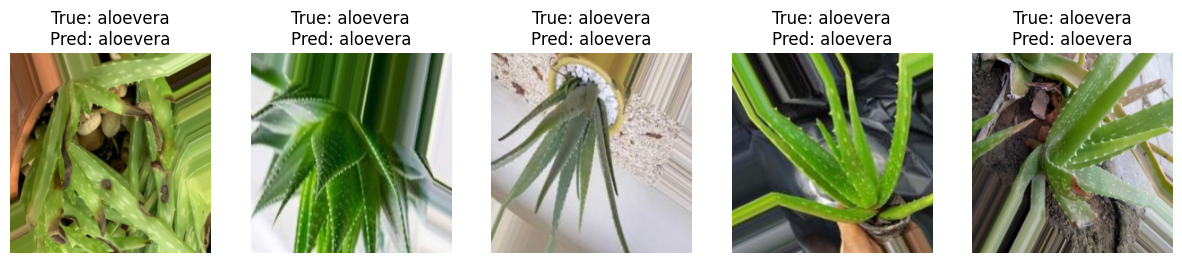

In [36]:
# Plot some test samples and their predictions
print("Plotting some test samples from Plant Dataset with predictions:")

# Get one batch of test data from the Plant Dataset test_loader
test_images_cifar, test_labels_cifar = next(iter(test_loader))

# Move images to the same device as the model and get predictions
# Assuming cifar10_model is already instantiated and trained
device = next(fine_tune_vgg_plant_model.parameters()).device # Get the device of the model
test_images_cifar = test_images_cifar.to(device)

with torch.no_grad(): # No need to calculate gradients for inference
    outputs = fine_tune_vgg_plant_model(test_images_cifar)
    # Get the index of the class with the highest probability
    _, predicted_labels_cifar = torch.max(outputs, 1)

# Move data back to CPU for plotting if needed
test_images_cifar = test_images_cifar.cpu()
test_labels_cifar = test_labels_cifar.cpu()
predicted_labels_cifar = predicted_labels_cifar.cpu()

# Display the first few images with true and predicted labels
fig_cifar, axes_cifar = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    # Unnormalize the image for display (Plant Dataset normalization used mean and std of 0.5)
    img_cifar = test_images_cifar[i] * 0.5 + 0.5     # Unnormalize
    npimg_cifar = img_cifar.numpy()
    # Matplotlib expects shape (height, width, channels)
    npimg_cifar = np.transpose(npimg_cifar, (1, 2, 0))

    axes_cifar[i].imshow(npimg_cifar)
    axes_cifar[i].set_title(f"True: {test_dataset.classes[test_labels_cifar[i]]}\nPred: {test_dataset.classes[predicted_labels_cifar[i]]}")
    axes_cifar[i].axis('off')

plt.show()

# 5️⃣ Pretrained model `EfficientNet B0`

# **2.5. Models:** Pretrained model `EfficientNet B0`

## Pretrained model `efficientnet_b0`


Load a pre-trained EfficientNet model `efficientnet_b0` from `torchvision.models` and modify its classifier to match the number of classes in the Plant Type Dataset.

In [13]:
# Load a pretrained EfficientNet-B0 model
efficientnet_b0 = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Modify the classifier for the number of classes in the dataset
# The classifier is a sequential module, and the last layer is the linear layer
# We need to find the number of input features to this last linear layer
num_ftrs_efficientnet = efficientnet_b0.classifier[-1].in_features

# Replace the last linear layer with a new one
efficientnet_b0.classifier[-1] = nn.Linear(num_ftrs_efficientnet, num_classes)

print("Pretrained EfficientNet-B0 Model with modified classifier:")
print(efficientnet_b0)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:01<00:00, 17.4MB/s]


Pretrained EfficientNet-B0 Model with modified classifier:
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activati

# **3.5. PyTorch Lightning**

## Visualizse the EfficientNet Plant Lightning Module



Wrap the model in a PyTorch Lightning Module, similar to the previous models, define the training, validation, and test steps, and configure the optimizer.



- First Module

In [15]:
class EfficientNetPlantLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters(ignore=['model'])
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        # Get num_classes from the modified classifier layer
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=self.model.classifier[-1].out_features)


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(outputs, labels))
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log('val_loss', loss)
        self.log('val_acc', self.accuracy(outputs, labels))
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy(outputs, labels))
        return loss


    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

# Instantiate the EfficientNet Lightning Module
# Pass the pre-configured efficientnet_b0 model instance
efficientnet_plant_model = EfficientNetPlantLightningModule(model=efficientnet_b0, learning_rate=0.001)

print("EfficientNet Plant Lightning Module defined.")
print(efficientnet_plant_model)

EfficientNet Plant Lightning Module defined.
EfficientNetPlantLightningModule(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
     

- Second module with more metrics

In [14]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score

class EfficientNetPlantLightningModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3, num_classes=30):
        super().__init__()
        self.save_hyperparameters(ignore=["model"])
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr

        # separate metric instances per stage
        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc   = MulticlassAccuracy(num_classes=num_classes)
        self.test_acc  = MulticlassAccuracy(num_classes=num_classes)

        self.val_precision = MulticlassPrecision(num_classes=num_classes, average="macro")
        self.val_recall    = MulticlassRecall(num_classes=num_classes, average="macro")
        self.val_f1        = MulticlassF1Score(num_classes=num_classes, average="macro")

        self.test_precision = MulticlassPrecision(num_classes=num_classes, average="macro")
        self.test_recall    = MulticlassRecall(num_classes=num_classes, average="macro")
        self.test_f1        = MulticlassF1Score(num_classes=num_classes, average="macro")

    def forward(self, x):
        return self.model(x)  # logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.train_acc(logits, y)

        # step + epoch logging
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=x.size(0))
        self.log("train_acc",  acc,  on_step=False, on_epoch=True, prog_bar=True, batch_size=x.size(0))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        acc = self.val_acc(logits, y)
        prec = self.val_precision(logits, y)
        rec  = self.val_recall(logits, y)
        f1   = self.val_f1(logits, y)

        # epoch-level metrics
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=x.size(0))
        self.log("val_acc",  acc,  on_step=False, on_epoch=True, prog_bar=True, batch_size=x.size(0))
        self.log("val_precision", prec, on_step=False, on_epoch=True, batch_size=x.size(0))
        self.log("val_recall",    rec,  on_step=False, on_epoch=True, batch_size=x.size(0))
        self.log("val_f1",        f1,   on_step=False, on_epoch=True, batch_size=x.size(0))

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        acc = self.test_acc(logits, y)
        prec = self.test_precision(logits, y)
        rec  = self.test_recall(logits, y)
        f1   = self.test_f1(logits, y)

        self.log("test_loss", loss, on_step=False, on_epoch=True, batch_size=x.size(0))
        self.log("test_acc",  acc,  on_step=False, on_epoch=True, batch_size=x.size(0))
        self.log("test_precision", prec, on_step=False, on_epoch=True, batch_size=x.size(0))
        self.log("test_recall",    rec,  on_step=False, on_epoch=True, batch_size=x.size(0))
        self.log("test_f1",        f1,   on_step=False, on_epoch=True, batch_size=x.size(0))

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=5e-4)


In [15]:
efficientnet_plant_model = EfficientNetPlantLightningModule(model=efficientnet_b0, lr=1e-3, num_classes=num_classes)

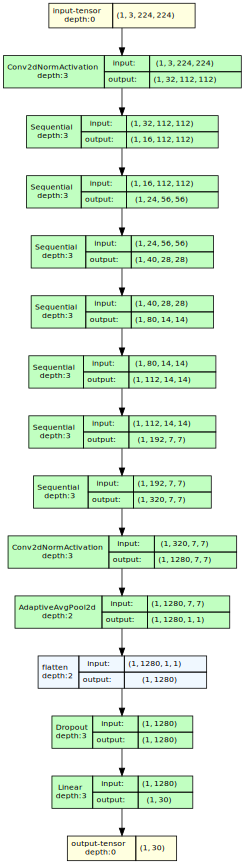

In [16]:
# Instantiate the EfficientNetPlantLightningModule for visualization
# We need to provide the same parameters as when it was defined
efficientnet_model_for_graph = EfficientNetPlantLightningModule(model=efficientnet_b0, lr=1e-3, num_classes=num_classes)

# Create a dummy input tensor for Plant Dataset images
# Assuming input images are 3 channels (RGB) and 224x224 pixels as per the transforms
dummy_input_plant = torch.randn(1, 3, 224, 224)

# Use draw_graph to visualize the EfficientNetPlantLightningModule
efficientnet_model_graph = draw_graph(
    model=efficientnet_model_for_graph,
    input_data=dummy_input_plant,
    graph_name='EfficientNetPlantLightningModule Visualization', # Name for the generated graph
    depth=3 # Set depth to 3
)

# Display the visual graph
efficientnet_model_graph.visual_graph

# **4.5. Training & Evaluation**
   - Train on the training set, tune with validation data.
   - Evaluate final models on the test set.
   - Compare metrics and analyze results.

## Train & Test the Pretrained Model `EfficientNetPlantLightningModule`


In [17]:
# Model Checkpoint Callback for EfficientNet
checkpoint_callback_efficientnet = ModelCheckpoint(
    monitor='val_acc',
    mode='max',
    dirpath='checkpoints_efficientnet_2/', # Use a different directory
    filename='best-efficientnet-plant-model',
    save_top_k=1,
    verbose=True
)

# Early Stopping Callback for EfficientNet
early_stopping_callback_efficientnet = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=True
)

# Learning Rate Monitor Callback
lr_monitor_callback_efficientnet = LearningRateMonitor(logging_interval='step')

# Instantiate the PyTorch Lightning Trainer for EfficientNet
trainer_efficientnet = pl.Trainer(
    max_epochs=10, # Train for 10 epochs
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback_efficientnet, early_stopping_callback_efficientnet, lr_monitor_callback_efficientnet]
)

# Start Training for EfficientNet
print("Starting EfficientNet Plant Dataset training with callbacks...")
trainer_efficientnet.fit(efficientnet_plant_model, train_loader, val_loader)

# Test the EfficientNet model after training
print("\nStarting EfficientNet Plant Dataset testing...")
# Test the model in its final state after training
trainer_efficientnet.test(efficientnet_plant_model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Starting EfficientNet Plant Dataset training with callbacks...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name           | Type                | Params | Mode 
----------------------------------------------------------------
0  | model          | EfficientNet        | 4.0 M  | train
1  | criterion      | CrossEntropyLoss    | 0      | train
2  | train_acc      | MulticlassAccuracy  | 0      | train
3  | val_acc        | MulticlassAccuracy  | 0      | train
4  | test_acc       | MulticlassAccuracy  | 0      | train
5  | val_precision  | MulticlassPrecision | 0      | train
6  | val_recall     | MulticlassRecall    | 0      | train
7  | val_f1         | MulticlassF1Score   | 0      | train
8  | test_precision | MulticlassPrecision | 0      | train
9  | test_recall    | MulticlassRecall    | 0      | train
10 | test_f1        | MulticlassF1Score   | 0      | train
----------------------------------------------------------------
4.0 M     Trainable params
0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.214
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 375: 'val_acc' reached 0.55276 (best 0.55276), saving model to '/content/checkpoints_efficientnet_2/best-efficientnet-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.098 >= min_delta = 0.0. New best score: 0.117
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 750: 'val_acc' reached 0.64638 (best 0.64638), saving model to '/content/checkpoints_efficientnet_2/best-efficientnet-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.088
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1125: 'val_acc' reached 0.73574 (best 0.73574), saving model to '/content/checkpoints_efficientnet_2/best-efficientnet-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1500: 'val_acc' reached 0.74185 (best 0.74185), saving model to '/content/checkpoints_efficientnet_2/best-efficientnet-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1875: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 2250: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.083
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 2625: 'val_acc' reached 0.74332 (best 0.74332), saving model to '/content/checkpoints_efficientnet_2/best-efficientnet-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.066
INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 3000: 'val_acc' reached 0.78090 (best 0.78090), saving model to '/content/checkpoints_efficientnet_2/best-efficientnet-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.060
INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 3375: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.050
INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 3750: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Starting EfficientNet Plant Dataset testing...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8437344431877136     │
│          test_f1          │    0.8460195064544678     │
│         test_loss         │   0.031887948513031006    │
│      test_precision       │    0.8484323024749756     │
│        test_recall        │    0.8437344431877136     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.031887948513031006,
  'test_acc': 0.8437344431877136,
  'test_precision': 0.8484323024749756,
  'test_recall': 0.8437344431877136,
  'test_f1': 0.8460195064544678}]

- We observe that the `EfficientNet` model performed the best out of all the models, as we have a minimum *test_loss* of **0.05** and the best *test_accuracy* of **0.71**

## Examine Pretrained EfficientNet model with Test Results

Following the training and testing of our Pretrained `EfficientNetPlant` model, this section visualizes several test images. We'll display the images alongside their true labels and the model's predictions to evaluate its performance on individual examples.

Plotting some test samples from Plant Dataset with predictions:


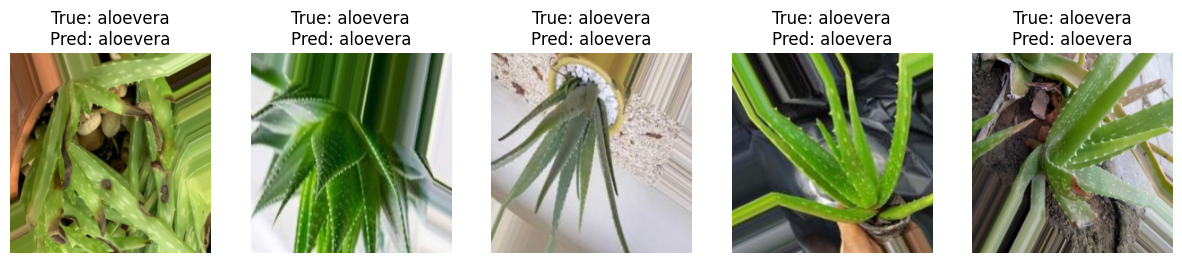

In [ ]:
# Plot some test samples and their predictions
print("Plotting some test samples from Plant Dataset with predictions:")

# Get one batch of test data from the Plant Dataset test_loader
test_images_cifar, test_labels_cifar = next(iter(test_loader))

# Move images to the same device as the model and get predictions
device = next(efficientnet_plant_model.parameters()).device # Get the device of the model
test_images_cifar = test_images_cifar.to(device)

with torch.no_grad(): # No need to calculate gradients for inference
    outputs = efficientnet_plant_model(test_images_cifar)
    # Get the index of the class with the highest probability
    _, predicted_labels_cifar = torch.max(outputs, 1)

# Move data back to CPU for plotting if needed
test_images_cifar = test_images_cifar.cpu()
test_labels_cifar = test_labels_cifar.cpu()
predicted_labels_cifar = predicted_labels_cifar.cpu()

# Display the first few images with true and predicted labels
fig_cifar, axes_cifar = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    # Unnormalize the image for display (Plant Dataset normalization used mean and std of 0.5)
    img_cifar = test_images_cifar[i] * 0.5 + 0.5     # Unnormalize
    npimg_cifar = img_cifar.numpy()
    # Matplotlib expects shape (height, width, channels)
    npimg_cifar = np.transpose(npimg_cifar, (1, 2, 0))

    axes_cifar[i].imshow(npimg_cifar)
    axes_cifar[i].set_title(f"True: {test_dataset.classes[test_labels_cifar[i]]}\nPred: {test_dataset.classes[predicted_labels_cifar[i]]}")
    axes_cifar[i].axis('off')

plt.show()

# 6️⃣ Pretrained model `EfficientNet B1`

# **2.6. Models:** Pretrained model `EfficientNet B1`

## Pretrained model `efficientnet_b1`


Load the pre-trained EfficientNet-B1 model (`efficientnet_b1`) from `torchvision.models` and modify its classifier to match the number of classes in the Plant Type Dataset.


In [13]:
# Load a pretrained EfficientNet-B1 model
efficientnet_b1 = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)

# Modify the classifier for the number of classes in the dataset
# The classifier is a sequential module, and the last layer is the linear layer
# We need to find the number of input features to this last linear layer
num_ftrs_efficientnet_b1 = efficientnet_b1.classifier[-1].in_features

# Replace the last linear layer with a new one
efficientnet_b1.classifier[-1] = nn.Linear(num_ftrs_efficientnet_b1, num_classes)

print("Pretrained EfficientNet-B1 Model with modified classifier:")
print(efficientnet_b1)

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth


100%|██████████| 30.1M/30.1M [00:00<00:00, 103MB/s]


Pretrained EfficientNet-B1 Model with modified classifier:
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activati

# **3.6. PyTorch Lightning**

## Visualizse the EfficientNet Plant Lightning Module



Create a PyTorch Lightning Module for the EfficientNet-B1 model, similar to the `EfficientNetPlantLightningModule` created earlier. This module will handle the training, validation, and testing steps, including logging the relevant metrics.


In [14]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score

class EfficientNetB1PlantLightningModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3, num_classes=30):
        super().__init__()
        self.save_hyperparameters(ignore=["model"])
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr

        # separate metric instances per stage
        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc   = MulticlassAccuracy(num_classes=num_classes)
        self.test_acc  = MulticlassAccuracy(num_classes=num_classes)

        self.val_precision = MulticlassPrecision(num_classes=num_classes, average="macro")
        self.val_recall    = MulticlassRecall(num_classes=num_classes, average="macro")
        self.val_f1        = MulticlassF1Score(num_classes=num_classes, average="macro")

        self.test_precision = MulticlassPrecision(num_classes=num_classes, average="macro")
        self.test_recall    = MulticlassRecall(num_classes=num_classes, average="macro")
        self.test_f1        = MulticlassF1Score(num_classes=num_classes, average="macro")

    def forward(self, x):
        return self.model(x)  # logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.train_acc(logits, y)

        # step + epoch logging
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=x.size(0))
        self.log("train_acc",  acc,  on_step=False, on_epoch=True, prog_bar=True, batch_size=x.size(0))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        acc = self.val_acc(logits, y)
        prec = self.val_precision(logits, y)
        rec  = self.val_recall(logits, y)
        f1   = self.val_f1(logits, y)

        # epoch-level metrics
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=x.size(0))
        self.log("val_acc",  acc,  on_step=False, on_epoch=True, prog_bar=True, batch_size=x.size(0))
        self.log("val_precision", prec, on_step=False, on_epoch=True, batch_size=x.size(0))
        self.log("val_recall",    rec,  on_step=False, on_epoch=True, batch_size=x.size(0))
        self.log("val_f1",        f1,   on_step=False, on_epoch=True, batch_size=x.size(0))

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        acc = self.test_acc(logits, y)
        prec = self.test_precision(logits, y)
        rec  = self.test_recall(logits, y)
        f1   = self.test_f1(logits, y)

        self.log("test_loss", loss, on_step=False, on_epoch=True, batch_size=x.size(0))
        self.log("test_acc",  acc,  on_step=False, on_epoch=True, batch_size=x.size(0))
        self.log("test_precision", prec, on_step=False, on_epoch=True, batch_size=x.size(0))
        self.log("test_recall",    rec,  on_step=False, on_epoch=True, batch_size=x.size(0))
        self.log("test_f1",        f1,   on_step=False, on_epoch=True, batch_size=x.size(0))

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=5e-4)

# Instantiate the EfficientNetB1 Lightning Module
efficientnet_b1_plant_model = EfficientNetB1PlantLightningModule(model=efficientnet_b1, lr=1e-3, num_classes=num_classes)

print("EfficientNet-B1 Plant Lightning Module defined.")
print(efficientnet_b1_plant_model)

EfficientNet-B1 Plant Lightning Module defined.
EfficientNetB1PlantLightningModule(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))


Instantiate the Lightning Module, create a dummy input, and visualize the graph using torchview.



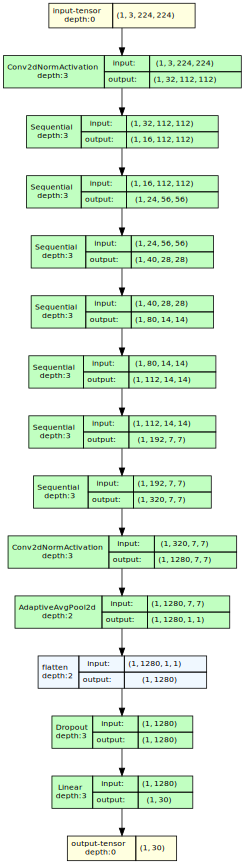

In [15]:
# Instantiate the EfficientNetB1PlantLightningModule for visualization
# We need to provide the same parameters as when it was defined
efficientnet_b1_model_for_graph = EfficientNetB1PlantLightningModule(model=efficientnet_b1, lr=1e-3, num_classes=num_classes)

# Create a dummy input tensor for Plant Dataset images
# Assuming input images are 3 channels (RGB) and 224x224 pixels as per the transforms
dummy_input_plant = torch.randn(1, 3, 224, 224)

# Use draw_graph to visualize the EfficientNetB1PlantLightningModule
efficientnet_b1_model_graph = draw_graph(
    model=efficientnet_b1_model_for_graph,
    input_data=dummy_input_plant,
    graph_name='EfficientNetB1PlantLightningModule Visualization', # Name for the generated graph
    depth=3 # Set depth to 3
)

# Display the visual graph
efficientnet_b1_model_graph.visual_graph

# **4.6. Training & Evaluation**
   - Train on the training set, tune with validation data.
   - Evaluate final models on the test set.
   - Compare metrics and analyze results.

## Train & Test the Pretrained Model `EfficientNetB1PlantLightningModule`


In [16]:
# Model Checkpoint Callback for EfficientNet-B1
checkpoint_callback_efficientnet_b1 = ModelCheckpoint(
    monitor='val_acc',
    mode='max',
    dirpath='checkpoints_efficientnet_b1/', # Use a distinct directory
    filename='best-efficientnet-b1-plant-model',
    save_top_k=1,
    verbose=True
)

# Early Stopping Callback for EfficientNet-B1
early_stopping_callback_efficientnet_b1 = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=True
)

# Learning Rate Monitor Callback
lr_monitor_callback_efficientnet_b1 = LearningRateMonitor(logging_interval='step')

# Instantiate the PyTorch Lightning Trainer for EfficientNet-B1
trainer_efficientnet_b1 = pl.Trainer(
    max_epochs=10, # Train for 10 epochs
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback_efficientnet_b1, early_stopping_callback_efficientnet_b1, lr_monitor_callback_efficientnet_b1]
)

# Start Training for EfficientNet-B1
print("Starting EfficientNet-B1 Plant Dataset training with callbacks...")
trainer_efficientnet_b1.fit(efficientnet_b1_plant_model, train_loader, val_loader)

# Test the EfficientNet-B1 model after training
print("\nStarting EfficientNet-B1 Plant Dataset testing...")
# Test the model in its final state after training
trainer_efficientnet_b1.test(efficientnet_b1_plant_model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Starting EfficientNet-B1 Plant Dataset training with callbacks...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name           | Type                | Params | Mode 
----------------------------------------------------------------
0  | model          | EfficientNet        | 6.6 M  | train
1  | criterion      | CrossEntropyLoss    | 0      | train
2  | train_acc      | MulticlassAccuracy  | 0      | train
3  | val_acc        | MulticlassAccuracy  | 0      | train
4  | test_acc       | MulticlassAccuracy  | 0      | train
5  | val_precision  | MulticlassPrecision | 0      | train
6  | val_recall     | MulticlassRecall    | 0      | train
7  | val_f1         | MulticlassF1Score   | 0      | train
8  | test_precision | MulticlassPrecision | 0      | train
9  | test_recall    | MulticlassRecall    | 0      | train
10 | test_f1        | MulticlassF1Score   | 0      | train
----------------------------------------------------------------
6.6 M     Trainable params
0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.126
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 375: 'val_acc' reached 0.62211 (best 0.62211), saving model to '/content/checkpoints_efficientnet_b1/best-efficientnet-b1-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.077
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 750: 'val_acc' reached 0.71167 (best 0.71167), saving model to '/content/checkpoints_efficientnet_b1/best-efficientnet-b1-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1125: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1500: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.047
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1875: 'val_acc' reached 0.80508 (best 0.80508), saving model to '/content/checkpoints_efficientnet_b1/best-efficientnet-b1-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 2250: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 2625: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 3000: 'val_acc' reached 0.81013 (best 0.81013), saving model to '/content/checkpoints_efficientnet_b1/best-efficientnet-b1-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 3375: 'val_acc' reached 0.81920 (best 0.81920), saving model to '/content/checkpoints_efficientnet_b1/best-efficientnet-b1-plant-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 0.047. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 3750: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Starting EfficientNet-B1 Plant Dataset testing...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7517418265342712     │
│          test_f1          │    0.7562273144721985     │
│         test_loss         │    0.06175730377435684    │
│      test_precision       │    0.7611517906188965     │
│        test_recall        │    0.7517418265342712     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.06175730377435684,
  'test_acc': 0.7517418265342712,
  'test_precision': 0.7611517906188965,
  'test_recall': 0.7517418265342712,
  'test_f1': 0.7562273144721985}]

- The `EfficinetNet_B1` model got the best accuracy out of all models, even better than `EfficientNet_B0`, of **0.75**.

## Examine Pretrained EfficientNet model with Test Results

Following the training and testing of our Pretrained `EfficientNetPlant` model, this section visualizes several test images. We'll display the images alongside their true labels and the model's predictions to evaluate its performance on individual examples.

Plotting some test samples from different Plant Dataset classes with predictions:


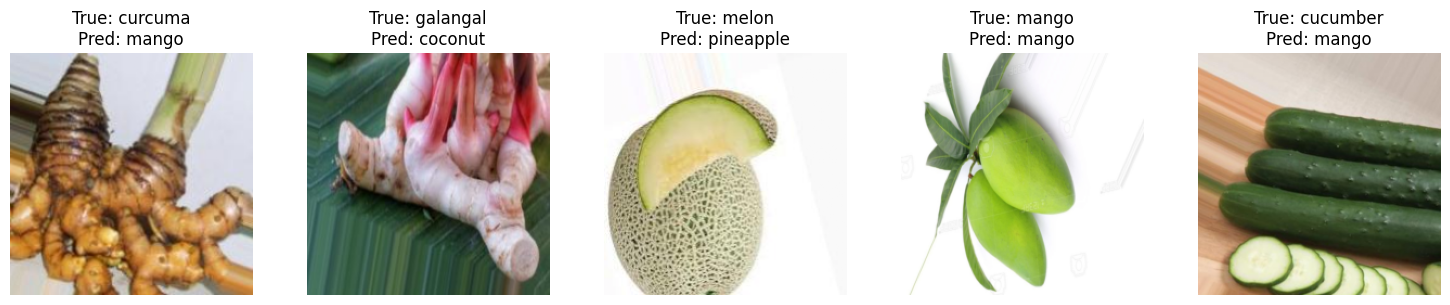

In [22]:
# Plot some test samples and their predictions from different classes
print("Plotting some test samples from different Plant Dataset classes with predictions:")

# Get indices of images from a few different classes for visualization
num_images_to_show = 5
images_to_plot = []
labels_to_plot = []
predicted_labels_to_plot = []
classes_shown = set()

# Define the mean and standard deviation used for normalization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)


# Iterate through the test dataset to find images from different classes
for i in range(len(test_dataset)):
    image, label = test_dataset[i]
    label_name = test_dataset.classes[label]

    # If we haven't shown this class yet and we still need more images
    if label_name not in classes_shown and len(images_to_plot) < num_images_to_show:
        # Move image to the same device as the model and get prediction
        device = next(efficientnet_b1_plant_model.parameters()).device
        image_tensor = image.unsqueeze(0).to(device) # Add batch dimension and move to device

        with torch.no_grad():
            outputs = efficientnet_b1_plant_model(image_tensor)
            _, predicted_label_tensor = torch.max(outputs, 1)
            predicted_label = predicted_label_tensor.item() # Get the scalar value

        # Move image back to CPU for plotting and store
        images_to_plot.append(image.cpu())
        labels_to_plot.append(label)
        predicted_labels_to_plot.append(predicted_label)
        classes_shown.add(label_name)

    # Stop once we have enough images
    if len(images_to_plot) == num_images_to_show:
        break

# Display the selected images with true and predicted labels
fig_cifar, axes_cifar = plt.subplots(1, num_images_to_show, figsize=(15, 3))

for i in range(num_images_to_show):
    # Unnormalize the image for display using the correct mean and std
    img_cifar = images_to_plot[i] * std + mean
    npimg_cifar = img_cifar.numpy()
    # Matplotlib expects shape (height, width, channels)
    npimg_cifar = np.transpose(npimg_cifar, (1, 2, 0))

    axes_cifar[i].imshow(npimg_cifar)
    axes_cifar[i].set_title(f"True: {test_dataset.classes[labels_to_plot[i]]}\nPred: {test_dataset.classes[predicted_labels_to_plot[i]]}")
    axes_cifar[i].axis('off')

plt.tight_layout()
plt.show()

# 7️⃣ Docker Image

Download the `EfficientNet_B0` model.

In [18]:
import torch
from joblib import dump

# Save the model weights for the EfficientNet-B0 model
torch.save(efficientnet_plant_model.state_dict(), 'efficientnet_b0_plants.pt')

# If you used any preprocessing (like image transforms or scalers), save them too
# Get the mean and std from your defined transforms
# These were defined as torch.tensor([0.485, 0.456, 0.406]) and torch.tensor([0.229, 0.224, 0.225])
# Convert them to lists for saving
mean_list = [0.485, 0.456, 0.406]
std_list = [0.229, 0.224, 0.225]
image_size = 224 # Your defined image size

# Get the class names from your dataset
# Assuming 'train_dataset' is available and has a 'classes' attribute
class_names = train_dataset.classes

preprocessing_params = {
    'mean': mean_list,
    'std': std_list,
    'image_size': image_size,
    'classes': class_names # Your actual plant classes
}

dump(preprocessing_params, 'preprocessing_params.joblib', compress=True)

# Download these files from Colab
from google.colab import files
files.download('efficientnet_b0_plants.pt')
files.download('preprocessing_params.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>